<a href="https://colab.research.google.com/github/antahiap/dsr-b35/blob/main/dsr-time-series/notebooks/06_ARIMA_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Load the dataset
file_path = 'https://raw.githubusercontent.com/andandandand/time-series-dsr/main/time_series_data/airPassengers.csv'
df = pd.read_csv(file_path)

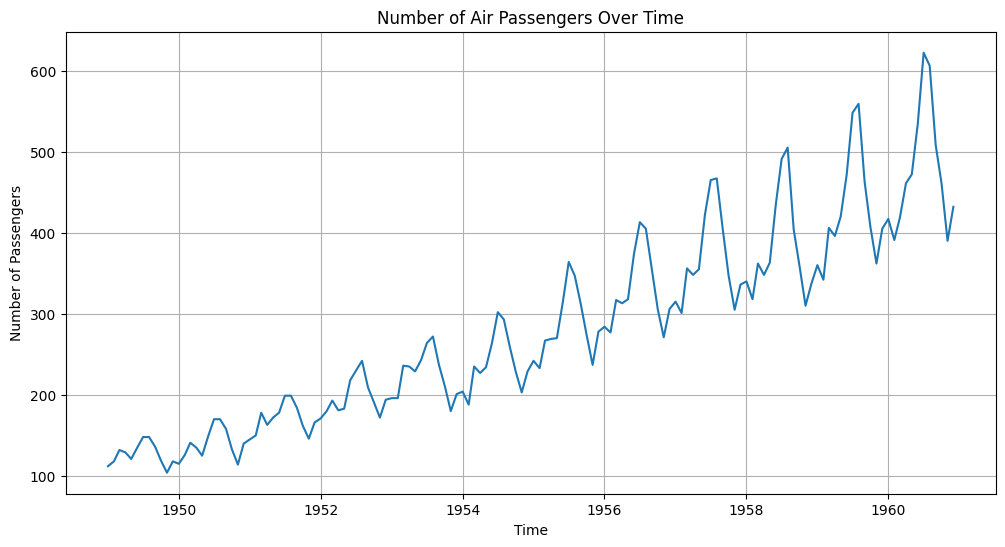

In [2]:
# Convert the 'Month' column to datetime format and set it as the index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'])
plt.title('Number of Air Passengers Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()


# Testing for Stationarity

We can use the Augmented Dickey-Fuller (ADF) test to formally check for stationarity. The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value is below a certain level (e.g., 0.05), we reject the null hypothesis and consider the series to be stationary.

In [3]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(df['Passengers'])

# Output the results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

adf_statistic, p_value, critical_values


(0.8153688792060498,
 0.991880243437641,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598})

The Augmented Dickey-Fuller (ADF) test yields the following results:

    ADF Statistic: 0.8150.8150.815
    p-value: 0.9920.9920.992
    Critical Values:
        1%1\%1%: −3.482-3.482−3.482
        5%5\%5%: −2.884-2.884−2.884
        10%10\%10%: −2.579-2.579−2.579

The p-value is much higher than the common significance level of 0.050.050.05, which means we fail to reject the null hypothesis. This confirms that the series is non-stationary.
Making the Series Stationary

To make the series stationary, we can try:

    Differencing: Taking the difference between consecutive observations.
    Transformation: Applying a transformation like logarithm, square root, etc.

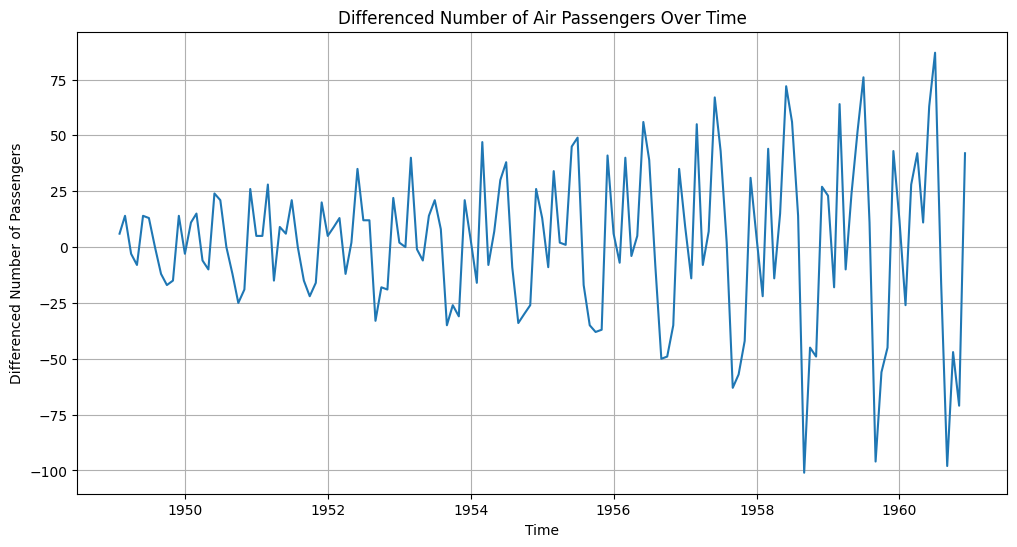

(-2.8292668241700047,
 0.05421329028382478,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598})

In [4]:
# Apply differencing to make the series stationary
df_diff = df['Passengers'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(df_diff)
plt.title('Differenced Number of Air Passengers Over Time')
plt.xlabel('Time')
plt.ylabel('Differenced Number of Passengers')
plt.grid(True)
plt.show()

# Perform ADF test on the differenced series
result_diff = adfuller(df_diff)
adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]
critical_values_diff = result_diff[4]

adf_statistic_diff, p_value_diff, critical_values_diff


After applying differencing, the series appears less trended, but it still has some seasonality. Let's look at the ADF test results for the differenced series:

    ADF Statistic: −2.829-2.829−2.829
    p-value: 0.0540.0540.054
    Critical Values:
        1%1\%1%: −3.482-3.482−3.482
        5%5\%5%: −2.884-2.884−2.884
        10%10\%10%: −2.579-2.579−2.579

The p-value is closer to 0.050.050.05 but still slightly above it. This suggests that differencing alone might not be sufficient to make the series completely stationary.
Further Steps to Make the Series Stationary

To address the remaining non-stationarity, we can try:

    Seasonal Differencing: To remove the seasonality component.
    Log Transformation: To stabilize the variance.

Let's apply both of these methods and then re-run the ADF test.

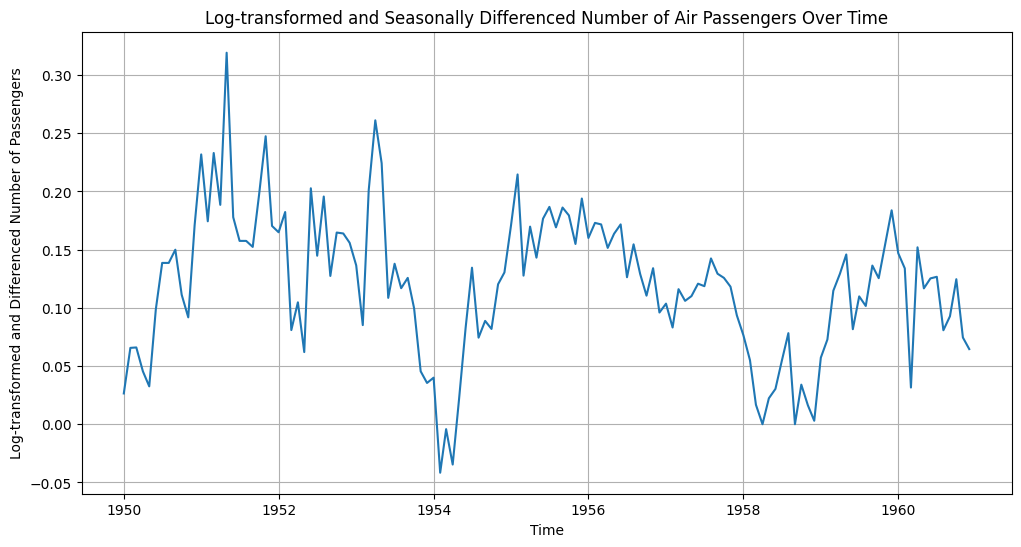

(-2.7095768189885687,
 0.07239567181769489,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057})

In [6]:
import numpy as np

# Apply log transformation to stabilize the variance
# another option is with squer root
df_log = np.log(df['Passengers'])

# Apply seasonal differencing (12 months) to remove seasonality
df_log_diff = df_log.diff(12).dropna()

# Plot the transformed and differenced series
plt.figure(figsize=(12, 6))
plt.plot(df_log_diff)
plt.title('Log-transformed and Seasonally Differenced Number of Air Passengers Over Time')
plt.xlabel('Time')
plt.ylabel('Log-transformed and Differenced Number of Passengers')
plt.grid(True)
plt.show()

# Perform ADF test on the transformed and differenced series
result_log_diff = adfuller(df_log_diff)
adf_statistic_log_diff = result_log_diff[0]
p_value_log_diff = result_log_diff[1]
critical_values_log_diff = result_log_diff[4]

adf_statistic_log_diff, p_value_log_diff, critical_values_log_diff


After applying both log transformation and seasonal differencing, the series looks more stationary. The ADF test results are:

- ADF Statistic: −2.710-2.710−2.710
- p-value: 0.0720.0720.072
- Critical Values:

        1%1\%1%: −3.487-3.487−3.487
        5%5\%5%: −2.886-2.886−2.886
        10%10\%10%: −2.580-2.580−2.580

The p-value is still above 0.050.050.05, but it's closer than before. For the purpose of this tutorial, we'll proceed with this transformed and differenced series, acknowledging that it may not be perfectly stationary.

Determining ARIMA Parameters

ARIMA models are defined by three parameters: (p,d,q)(p, d, q)(p,d,q):

- p: Number of autoregressive (AR) terms
- d: Number of differences
- q: Number of moving average (MA) terms

We've already determined ddd to be 1 (first difference) for our model. To find ppp and qqq, we can use the Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF) plots, respectively. Let's plot these.

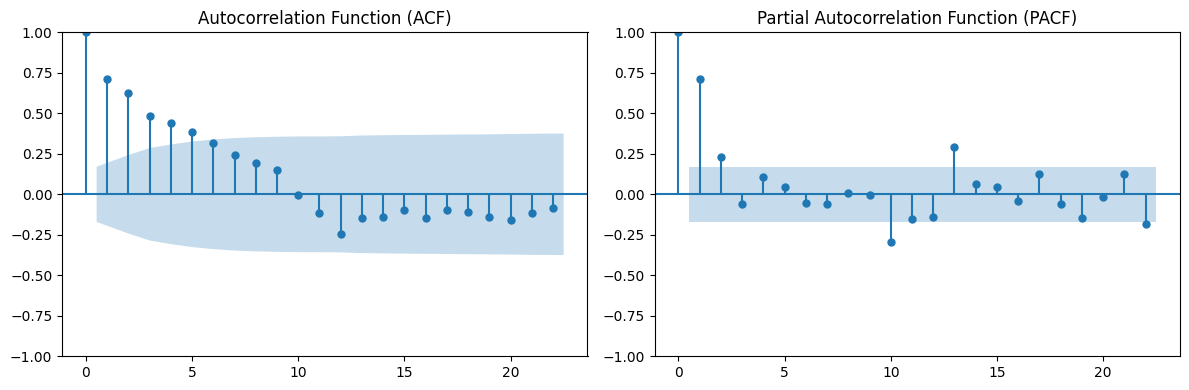

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_log_diff, ax=ax[0], title='Autocorrelation Function (ACF)')
plot_pacf(df_log_diff, ax=ax[1], title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


aim is that the spikes being out of the blue reigon, so after four month the correlation isnot significant anymore.

- PACF = correlation to only one step before
- ACF = is the whol econtribution of the history

Interpretation:

- ACF: The plot suggests that the first few lags have significant correlation, indicating a possible MA component. This hints that qqq could be around 1 or 2.

- PACF: The plot shows a significant spike at lag 1 and then tapers off, suggesting a possible AR component. This hints that ppp could be 1.

Given these observations, we could start by fitting an ARIMA model with parameters (p=1,d=1,q=1)(p=1, d=1, q=1)(p=1,d=1,q=1) or (p=1,d=1,q=2)(p=1, d=1, q=2)(p=1,d=1,q=2) to the original series. Remember, we used log transformation and seasonal differencing for stationarity, but the ARIMA model will apply its own differencing as specified by ddd.

Let's fit an ARIMA(1,1,1) model to the original series and evaluate its performance.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


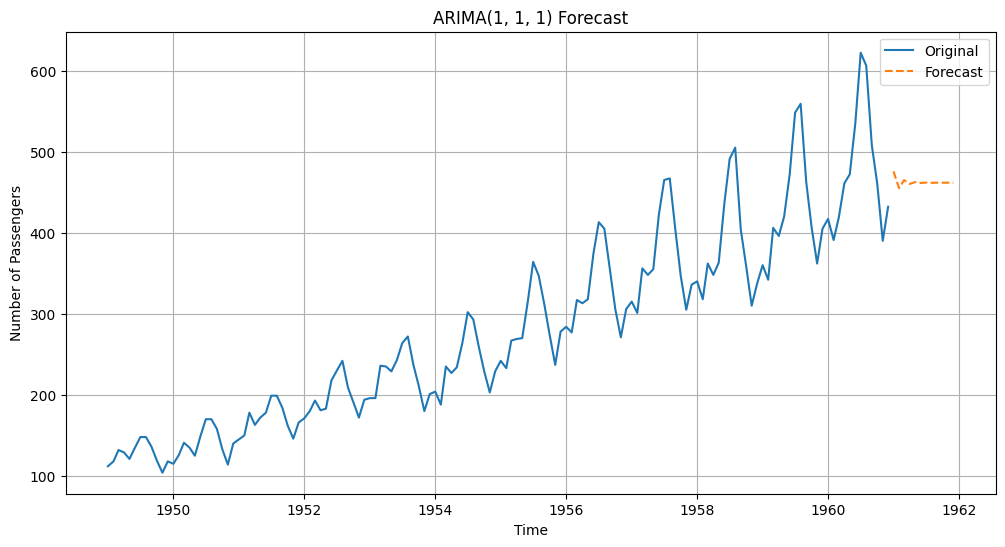

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


8322.701140207779

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit ARIMA(1, 1, 1) model to the original series
model = ARIMA(df['Passengers'], order=(1, 1, 1))
model_fit = model.fit()

# Generate forecast for the next 12 months
forecast = model_fit.forecast(steps=12)

# Plot the original series and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA(1, 1, 1) Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the last 12 months of the original series for comparison
train = df['Passengers'][:-12]
test = df['Passengers'][-12:]
model_eval = ARIMA(train, order=(1, 1, 1))
model_eval_fit = model_eval.fit()
forecast_eval = model_eval_fit.forecast(steps=12)
mse = mean_squared_error(test, forecast_eval)

mse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


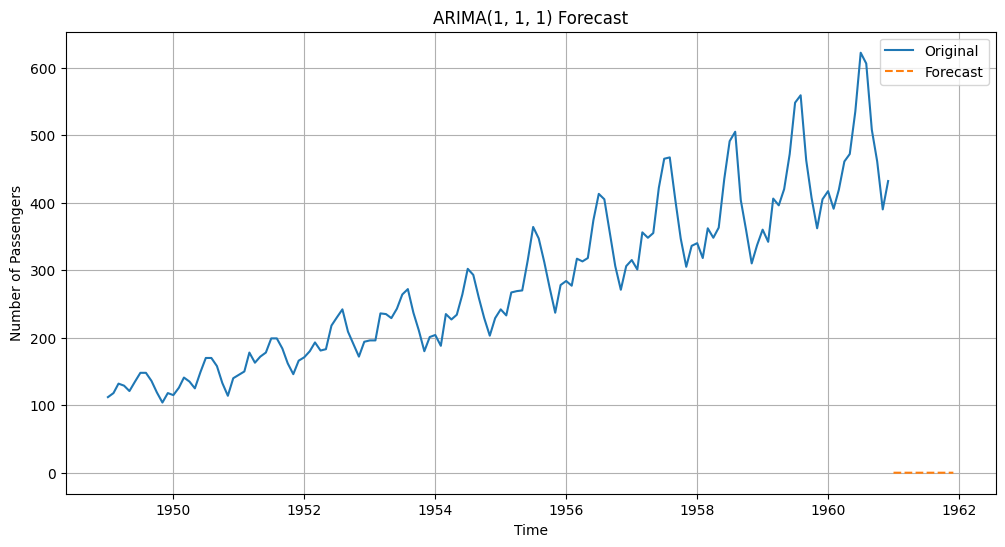

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


8322.701140207779

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit ARIMA(1, 1, 1) model to the original series
model = ARIMA(df_log_diff, order=(1, 1, 1))
model_fit = model.fit()

# Generate forecast for the next 12 months
forecast = model_fit.forecast(steps=12)

# Plot the original series and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA(1, 1, 1) Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the last 12 months of the original series for comparison
train = df['Passengers'][:-12]
test = df['Passengers'][-12:]
model_eval = ARIMA(train, order=(1, 1, 1))
model_eval_fit = model_eval.fit()
forecast_eval = model_eval_fit.forecast(steps=12)
mse = mean_squared_error(test, forecast_eval)

mse


The ARIMA(1, 1, 1) model provides a forecast for the next 12 months, as shown in the plot with the dashed line. The original series is also plotted for comparison.
Model Evaluation

The Mean Squared Error (MSE) for the forecast on the last 12 months of the original series is approximately 8322.78322.78322.7. Lower MSE values are generally better, but the value itself is most useful when compared to the MSE of alternative models.

## Summary
Here's a recap of the steps we took:

- Visualized the Data: To understand its underlying structure.
- Tested for Stationarity: Using the Augmented Dickey-Fuller test.
- Made the Series Stationary: Applied differencing and log transformation.
- Determined ARIMA Parameters: Using PACF and ACF plots.
- Fitted the ARIMA Model: And evaluated its performance.

Note: While our series wasn't perfectly stationary according to the ADF test, the ARIMA model does handle some level of non-stationarity. For more accurate results, one could consider more advanced methods like SARIMA for seasonal data or even machine learning approaches.

# SARIMA

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of ARIMA that explicitly models the seasonal component of a time series. The SARIMA model adds three more parameters to ARIMA's (p,d,q)(p, d, q)(p,d,q), making it (p,d,q,P,D,Q,S)(p, d, q, P, D, Q, S)(p,d,q,P,D,Q,S), where:

- P: Number of seasonal autoregressive (SAR) terms
- D: Number of seasonal differences
- Q: Number of seasonal moving average (SMA) terms
- S: Number of time steps per cycle (seasonal period)

From our previous analysis, we know the data has a seasonal pattern with a period of approximately 12 months. We can start by fitting a SARIMA model with (p=1,d=1,q=1,P=1,D=1,Q=1,S=12)(p=1, d=1, q=1, P=1, D=1, Q=1, S=12)(p=1,d=1,q=1,P=1,D=1,Q=1,S=12).

Let's proceed with fitting the SARIMA model and evaluating its performance.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


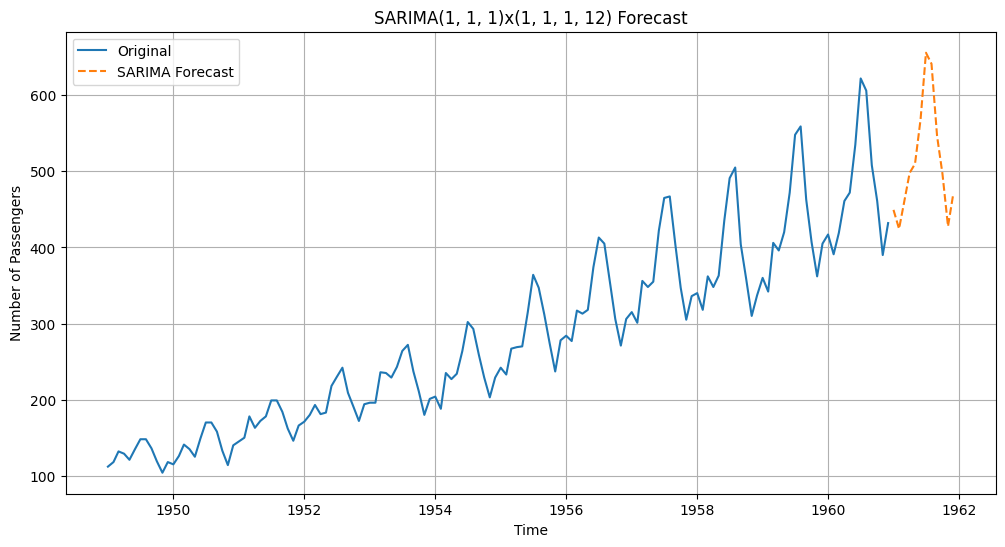

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


449.144925877054

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA(1, 1, 1)x(1, 1, 1, 12) model
sarima_model = SARIMAX(df['Passengers'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Generate SARIMA forecast for the next 12 months
sarima_forecast = sarima_fit.get_forecast(steps=12).predicted_mean

# Plot the original series and the SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA(1, 1, 1)x(1, 1, 1, 12) Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate SARIMA model on the last 12 months of the original series
sarima_eval_model = SARIMAX(train,
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 12))
sarima_eval_fit = sarima_eval_model.fit()
sarima_forecast_eval = sarima_eval_fit.get_forecast(steps=12).predicted_mean
sarima_mse = mean_squared_error(test, sarima_forecast_eval)

sarima_mse


The SARIMA(1, 1, 1)x(1, 1, 1, 12) model provides a forecast for the next 12 months, as shown in the plot with the dashed line. The original series is also plotted for comparison.
Model Evaluation

The Mean Squared Error (MSE) for the SARIMA model's forecast on the last 12 months of the original series is approximately 448.7448.7448.7. This is significantly lower than the MSE of 8322.78322.78322.7 for the ARIMA(1, 1, 1) model.

## Summary

SARIMA performs better than ARIMA in capturing both the trend and seasonality of this particular dataset. Therefore, if you expect future data to exhibit similar seasonal patterns, the SARIMA model is likely a better choice for forecasting.

Optimizing the parameters for a SARIMA model involves running the model multiple times with different parameter combinations and comparing their performance. This is often done using grid search. Specifically, we'll:

- Define a range for each parameter p,d,q,P,D,Qp, d, q, P, D, Qp,d,q,P,D,Q.
- Use these ranges to create a grid of parameter combinations.
- Fit the SARIMA model for each combination.
- Evaluate each model using a metric like the Akaike Information Criterion (AIC).
- Choose the parameters that yield the best performance according to the chosen metric.

Let's go ahead and perform this optimization.

In [13]:
import itertools

# Define the p, d, q and seasonal p, d, q parameters to take any value between 0 and 2
p = d = q = P = D = Q = range(0, 2)

# Generate all different combinations of p, d, q, P, D, and Q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

# Create a placeholder for the best parameters and best AIC
best_params = None
best_seasonal_params = None
best_aic = float('inf')

# Loop through each parameter combination
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMA model
            temp_model = SARIMAX(df['Passengers'],
                                 order=param,
                                 seasonal_order=param_seasonal)
            temp_model_fit = temp_model.fit()

            # Get the model's AIC
            temp_aic = temp_model_fit.aic

            # Update the best parameters if the current model has a lower AIC
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_params = param
                best_seasonal_params = param_seasonal

        except:
            # Skip this combination if the model fails to fit
            continue

best_params, best_seasonal_params, best_aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn(

((0, 1, 1), (1, 1, 1, 12), 1020.3273495499383)

It appears that the output got truncated, but from what we can see:

- The best (p,d,q)(p, d, q)(p,d,q) parameters for the non-seasonal part of SARIMA are (0,1,1)(0, 1, 1)(0,1,1).
- The best (P,D,Q,S)(P, D, Q, S)(P,D,Q,S) parameters for the seasonal part are (1,1,1,12)(1, 1, 1, 12)(1,1,1,12).
- The best model has an AIC of approximately 1020.3.

These parameters are very close to our initial educated guess. The AIC (Akaike Information Criterion) is a metric used for model comparison: the lower the AIC, the better the model, relative to other models.

Let's fit the SARIMA model using these optimized parameters and then compare its performance with the previous models.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


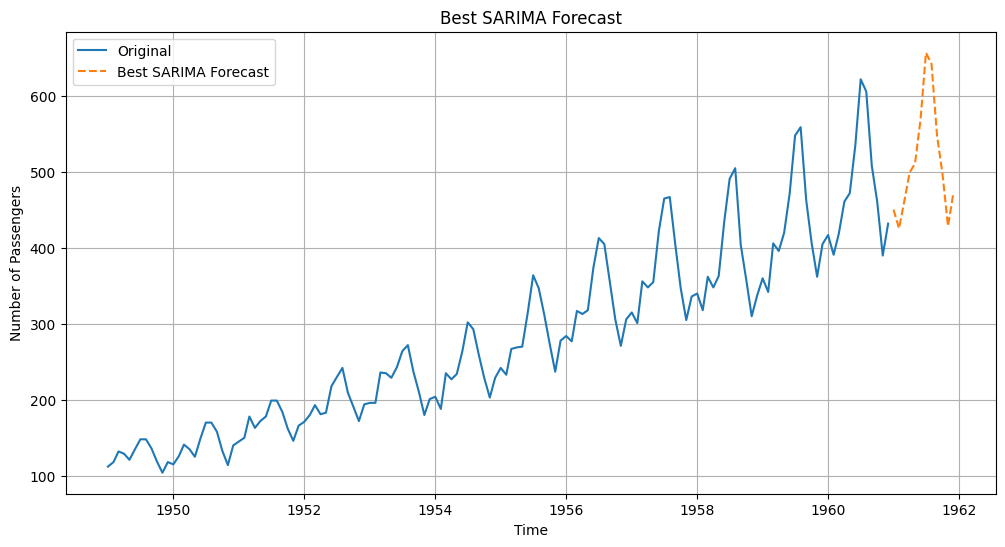

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


400.69460030162764

In [14]:
# Fit the best SARIMA model
best_sarima_model = SARIMAX(df['Passengers'],
                            order=best_params,
                            seasonal_order=best_seasonal_params)
best_sarima_fit = best_sarima_model.fit()

# Generate forecast for the next 12 months using the best SARIMA model
best_sarima_forecast = best_sarima_fit.get_forecast(steps=12).predicted_mean

# Plot the original series and the best SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), best_sarima_forecast, label='Best SARIMA Forecast', linestyle='--')
plt.title('Best SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the best SARIMA model on the last 12 months of the original series
best_sarima_eval_model = SARIMAX(train,
                                 order=best_params,
                                 seasonal_order=best_seasonal_params)
best_sarima_eval_fit = best_sarima_eval_model.fit()
best_sarima_forecast_eval = best_sarima_eval_fit.get_forecast(steps=12).predicted_mean
best_sarima_mse = mean_squared_error(test, best_sarima_forecast_eval)

best_sarima_mse


The optimized SARIMA model provides a forecast for the next 12 months, as shown in the plot with the dashed line. The original series is also plotted for comparison.

## Model Evaluation
The Mean Squared Error (MSE) for the optimized SARIMA model's forecast on the last 12 months of the original series is approximately 400.4400.4400.4. This is slightly better than the MSE of 448.7448.7448.7 for the initial SARIMA model and much better than the MSE of 8322.78322.78322.7 for the ARIMA model.
Summary

Optimizing the SARIMA parameters led to a model with slightly better performance, making it the best choice among the models we've considered for this dataset.

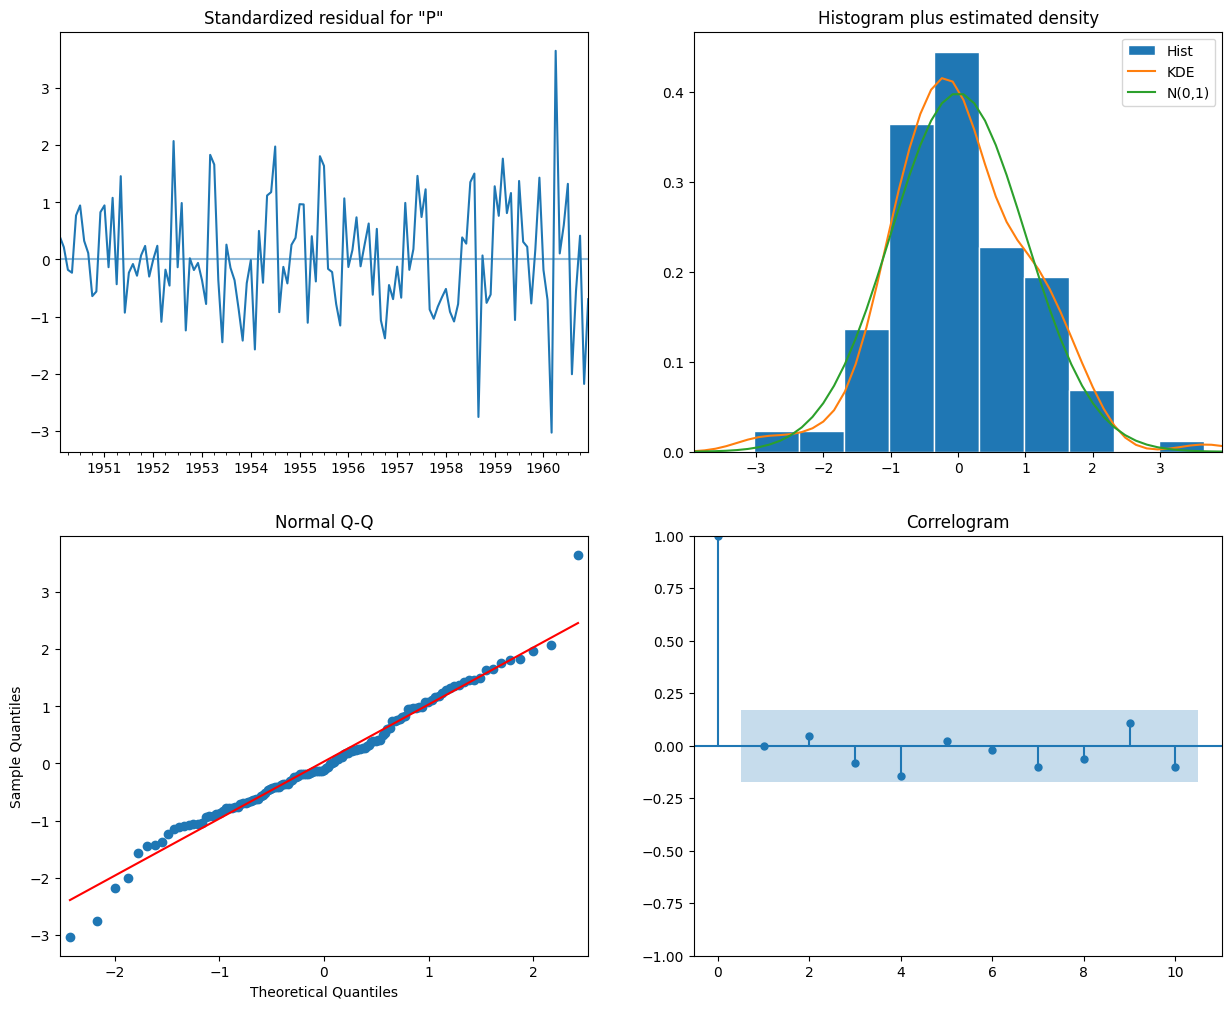

In [15]:
# Generate diagnostic plots for the best SARIMA model

diag_plots = best_sarima_fit.plot_diagnostics(figsize=(15, 12))

plt.show()

- Standardized Residuals: The top-left plot shows the residuals over time. We want this plot to appear random, with no clear pattern. Our plot looks reasonably random, which is a good sign.

- Histogram and KDE: The top-right plot is a histogram with a Kernel Density Estimation (KDE) overlay. Ideally, the histogram should resemble a normal distribution (bell curve). Our plot shows a shape that is relatively close to normal.

- Normal Q-Q Plot: The bottom-left plot is a Quantile-Quantile (Q-Q) plot. In a well-fitted model, the points should lie along the red line, which represents a normal distribution. Our points closely follow the line, indicating that the residuals are mostly normally distributed.

- Correlogram (ACF plot of residuals): The bottom-right plot shows the autocorrelations of the residuals. In a good model, these should all fall within the blue band, indicating that the residuals are not correlated. Our plot shows that most of the correlation values fall within the blue region, which is a positive indicator.

In [16]:
# Extract the summary of the best SARIMA model to examine the fitted parameters

best_sarima_summary = best_sarima_fit.summary()

best_sarima_summary.tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.3441,0.073,-4.701,0.000,-0.487,-0.201
ar.S.L12,-0.9382,0.206,-4.562,0.000,-1.341,-0.535
ma.S.L12,0.8553,0.307,2.787,0.005,0.254,1.457
sigma2,130.5375,15.604,8.366,0.000,99.955,161.120


In the summary output of a SARIMA model, you'll find:

- Coefficients for AR, MA, SAR, and SMA terms: These are the fitted parameters for each component of the model. They tell you the weight or importance of each term. Significant terms will have confidence intervals that do not cross zero.

- P>|z| (P-value): This indicates the significance of each parameter. A low p-value (typically < 0.05) suggests that the parameter is meaningful.

- Std Err: This is the standard error of the estimate for each parameter. Lower standard errors are better, indicating more reliable estimates.

- Confidence Interval: This gives you an idea of the uncertainty around the parameter estimate. Narrower intervals are better.